In [25]:
from __future__ import absolute_import, division, print_function

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error

from null_model import NullModel

np.random.seed(1234)

In [26]:
matplotlib.rcParams.update({'font.size': 16})

# Within-County Regression

In [3]:
data = pickle.load(open('data/processed_data/clean_regression_2017', 'rb'))
idxs = data[:, 0]
data = data[:, 1:]
data[:, 3] = data[:, 3] + data[:, 2]
data = data[:, 3:]
print(idxs.shape, data.shape)

(3093,) (3093, 4)


In [4]:
feature_to_name = {
    0: 'index',
    #1: '% less than HS diploma',
    #2: '% only HS diploma',
    #3: '% some college',
    1: '% some college or greater',
    2: 'population',
    3: '% in poverty',
    4: '% unemployed',
}

% some college or greater 51.71008729388942 10.638378042881463
% in poverty 15.390300678952473 6.245691926695084
% unemployed 4.556870352408665 1.5675094387631234


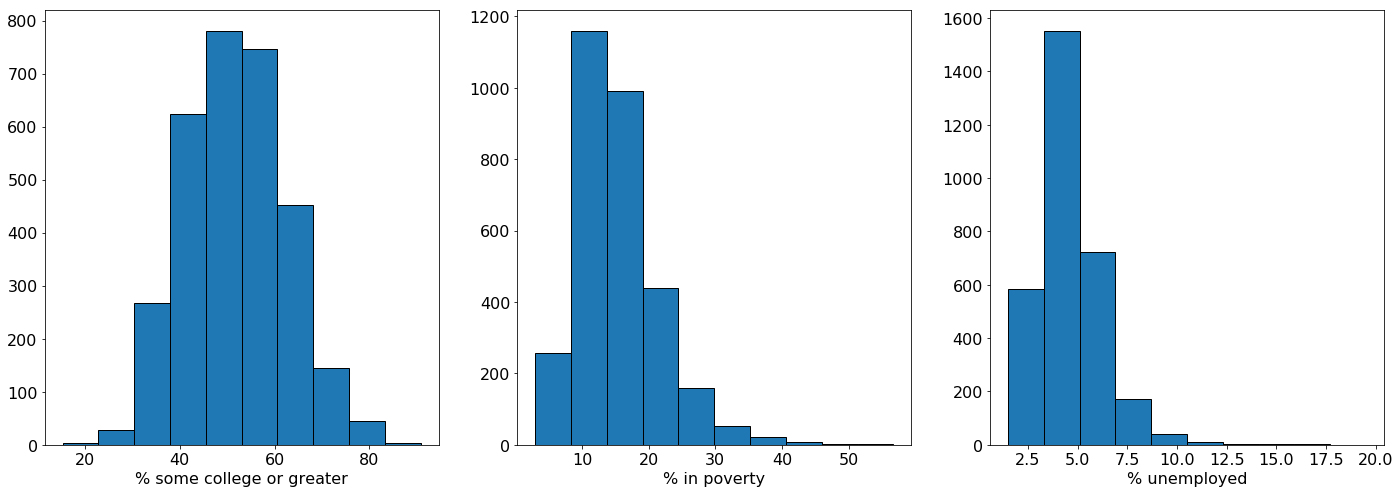

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
idx = 0
for i in [1, 3, 4]:
    print(feature_to_name[i], np.mean(data[:, i - 1]), np.std(data[:, i - 1]))
    axes[idx].hist(data[:, i - 1], edgecolor='black')
    axes[idx].set_xlabel(feature_to_name[i])
    idx += 1
plt.show()

## Baseline: Use mean of each feature in training set

In [6]:
def baseline(data, num_folds=5, labels=None, seed=1234):
    if labels is None:
        labels = np.arange(data.shape[1])
        
    for label in labels:
        if feature_to_name[label + 1] == 'population':
            continue
        
        kf = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
        data_idxs = np.delete(np.arange(data.shape[1]), label)
        x = data[:, data_idxs]
        y = data[:, label]
        
        mses = []
        maes = []
        for train_idx, test_idx in kf.split(x, y):
            x_train, y_train = x[train_idx], y[train_idx]
            x_test, y_test = x[test_idx], y[test_idx]
           
            y_pred = np.array([np.mean(y_train)] * len(y_test))
            
            mses.append(mean_squared_error(y_test, y_pred))
            maes.append(mean_absolute_error(y_test, y_pred))
        
        print('\n=== {} ==='.format(feature_to_name[label + 1]))
        print('Mean Squared Error: mean = {}, median = {}, std = {}, min = {}, max = {}'.format(np.mean(mses), np.median(mses), np.std(mses), np.min(mses), np.max(mses)))
        print('Mean Absolute Error: mean = {}, median = {}, std = {}, min = {}, max = {}'.format(np.mean(maes), np.median(maes), np.std(maes), np.min(maes), np.max(maes)))
        print('Label stats: min = {}, max = {}, mean = {}, std = {}'.format(np.min(y), np.max(y), np.mean(y), np.std(y)))

In [7]:
baseline(data)


=== % some college or greater ===
Mean Squared Error: mean = 113.26990843787814, median = 116.38549446929802, std = 5.455845780614538, min = 103.4575691924363, max = 118.55253002967949
Mean Absolute Error: mean = 8.625020645384636, median = 8.710543383008817, std = 0.26286909935308966, min = 8.22258958517211, max = 8.898037032635369
Label stats: min = 15.3, max = 90.8, mean = 51.71008729388942, std = 10.638378042881463

=== % in poverty ===
Mean Squared Error: mean = 39.0452558638413, median = 38.443387109902595, std = 3.048639302374546, min = 35.09067157713053, max = 42.71644089954392
Mean Absolute Error: mean = 4.743236096427919, median = 4.654315125363669, std = 0.14987474385044622, min = 4.585279395900756, max = 4.935310231251543
Label stats: min = 3.0, max = 56.7, mean = 15.390300678952473, std = 6.245691926695084

=== % unemployed ===
Mean Squared Error: mean = 2.459206058581443, median = 2.3683195539116917, std = 0.3265026556698756, min = 2.178438524335242, max = 3.092293615571

## Regression using within-county features

In [8]:
def do_regression(data, num_folds=5, labels=None, seed=1234):
    if labels is None:
        labels = np.arange(data.shape[1])
        
    for label in labels:
        if feature_to_name[label + 1] == 'population':
            continue
        
        kf = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
        data_idxs = np.delete(np.arange(data.shape[1]), label)
        x = data[:, data_idxs]
        # This does z-score normalization of data
        x = (x - np.mean(x, axis=0)) / np.std(x, axis=0)
        y = data[:, label]
        
        mses = []
        maes = []
        for train_idx, test_idx in kf.split(x, y):
            x_train, y_train = x[train_idx], y[train_idx]
            x_test, y_test = x[test_idx], y[test_idx]
           
            model = LinearRegression(normalize=False, n_jobs=-1).fit(x_train, y_train)
            y_pred = model.predict(x_test)
            
            mses.append(mean_squared_error(y_test, y_pred))
            maes.append(mean_absolute_error(y_test, y_pred))
        
        print('\n=== {} ==='.format(feature_to_name[label + 1]))
        print('Mean Squared Error: mean = {}, median = {}, std = {}, min = {}, max = {}'.format(np.mean(mses), np.median(mses), np.std(mses), np.min(mses), np.max(mses)))
        print('Mean Absolute Error: mean = {}, median = {}, std = {}, min = {}, max = {}'.format(np.mean(maes), np.median(maes), np.std(maes), np.min(maes), np.max(maes)))
        print('Label stats: min = {}, max = {}, mean = {}, std = {}'.format(np.min(y), np.max(y), np.mean(y), np.std(y)))

In [9]:
do_regression(data)


=== % some college or greater ===
Mean Squared Error: mean = 71.42953510583877, median = 70.90388508031926, std = 8.910002168362329, min = 58.68196649225366, max = 85.69738365058515
Mean Absolute Error: mean = 6.549494566871806, median = 6.5425416640528065, std = 0.3100061945847617, min = 6.026671635954233, max = 6.910694394511221
Label stats: min = 15.3, max = 90.8, mean = 51.71008729388942, std = 10.638378042881463

=== % in poverty ===
Mean Squared Error: mean = 20.669302412904507, median = 20.739644272278923, std = 1.6022669630452953, min = 17.877650677496977, max = 22.69606586639621
Mean Absolute Error: mean = 3.3330070582886955, median = 3.306425732534178, std = 0.06059309867065745, min = 3.249294677643827, max = 3.4053375446233356
Label stats: min = 3.0, max = 56.7, mean = 15.390300678952473, std = 6.245691926695084

=== % unemployed ===
Mean Squared Error: mean = 1.6050542189134913, median = 1.4720478213663863, std = 0.28754233537609164, min = 1.2977195786269138, max = 2.12573

Note that I also tried Ridge and Lasso regression and neither improved performance. Our task isn't complex enough to require regularization.

In [10]:
def plot_concordance(data, labels=None, seed=1234):
    if labels is None:
        labels = np.arange(data.shape[1])
        
    fig, axes = plt.subplots(2, 3, figsize=(24, 16))
    idx = 0
    for label in labels:
        if feature_to_name[label + 1] == 'population':
            continue
        
        kf = KFold(n_splits=2, shuffle=True, random_state=seed)
        data_idxs = np.delete(np.arange(data.shape[1]), label)
        x = data[:, data_idxs]
        # This does z-score normalization of data
        x = (x - np.mean(x, axis=0)) / np.std(x, axis=0)
        y = data[:, label]
        
        for train_idx, test_idx in kf.split(x, y):
            x_train, y_train = x[train_idx], y[train_idx]
            x_test, y_test = x[test_idx], y[test_idx]
           
            model = LinearRegression(normalize=False, n_jobs=-1).fit(x_train, y_train)
            y_pred = model.predict(x_test)
            
            axes[0, idx].scatter(y_test, y_pred, s=20)
            axes[0, idx].plot(np.arange(np.min(y_test), np.max(y_test)), np.arange(np.min(y_test), np.max(y_test)), color='red')
            axes[0, idx].set_xlabel('True Value')
            axes[0, idx].set_ylabel('Predicted Value')
            axes[0, idx].set_title('Concordance for {}'.format(feature_to_name[label + 1]))
            
            im = axes[1, idx].matshow(model.coef_[np.newaxis, :], cmap='RdBu')
            plt.colorbar(im, ax=axes[1, idx], orientation='horizontal')
            axes[1, idx].set_yticks([], [])
            axes[1, idx].set_xticklabels([''] + [feature_to_name[i + 1] for i in data_idxs])
            
            idx += 1
            break
    plt.tight_layout()
    plt.show()

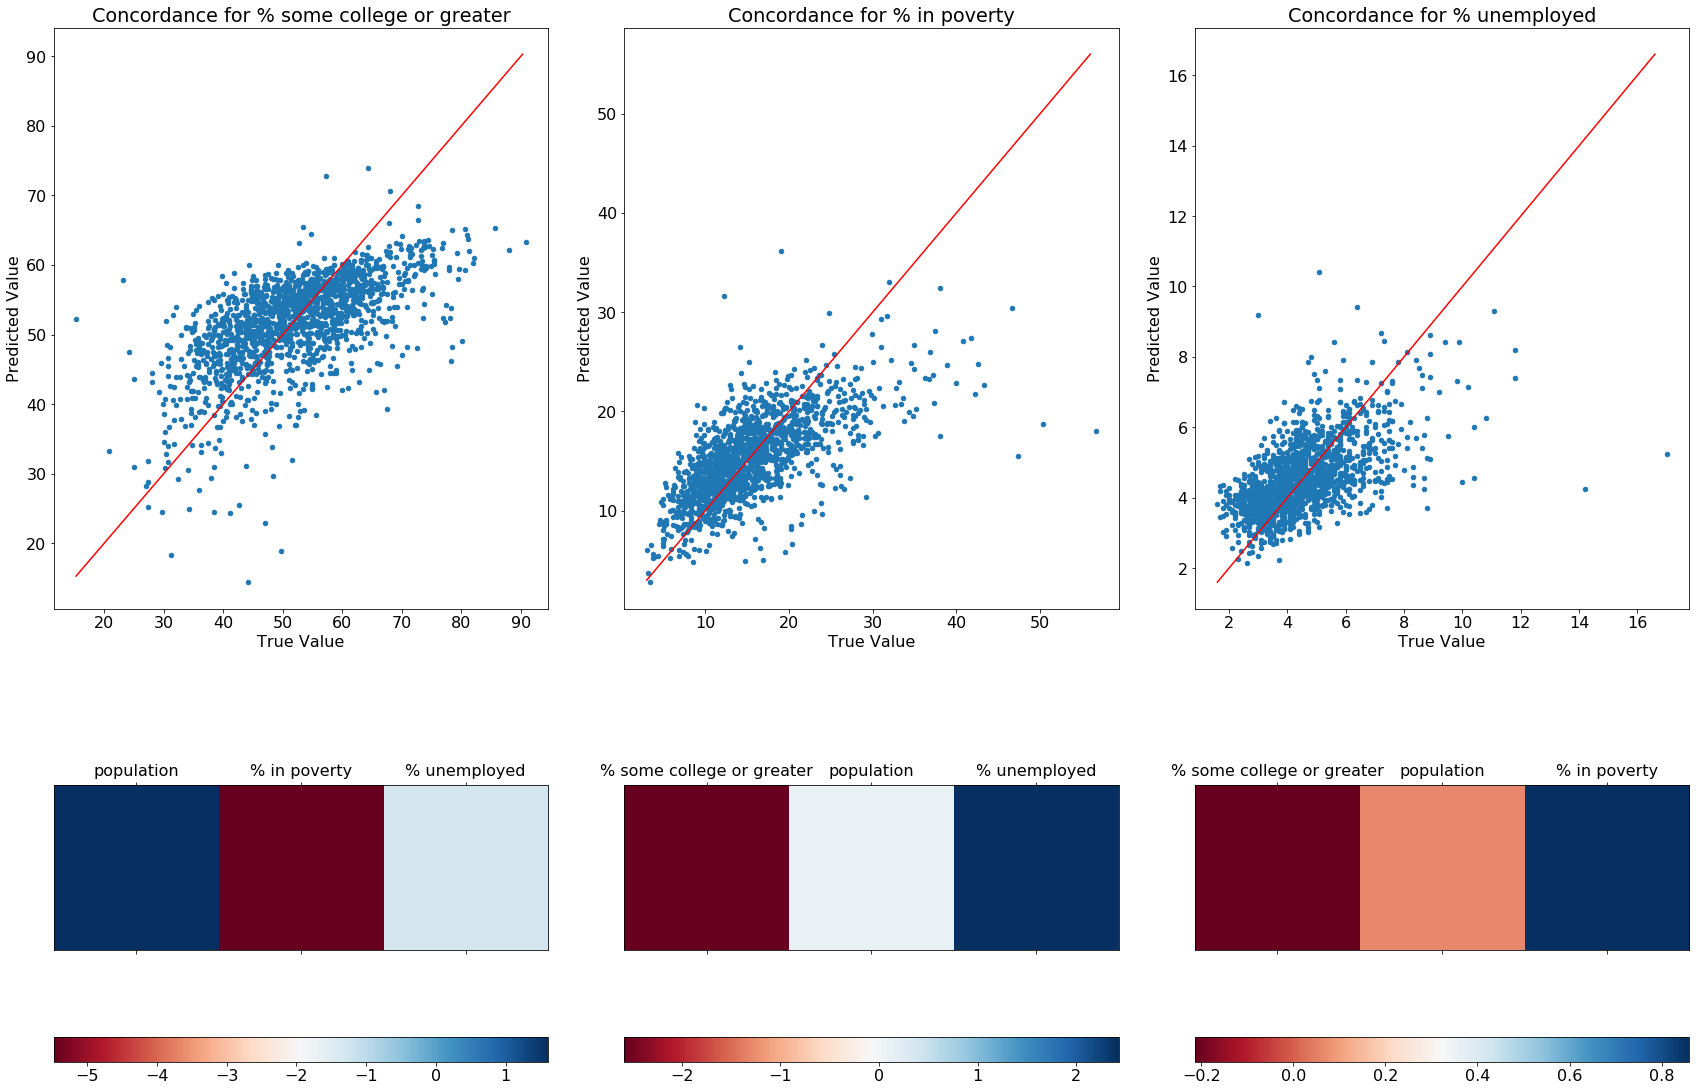

In [11]:
plot_concordance(data)

# Neighbor Regression

In [27]:
data = pickle.load(open('data/processed_data/clean_regression_2017', 'rb'))
adj_list = pickle.load(open('data/processed_data/adj_list', 'rb'))
idxs = data[:, 0]

neighbor_data = []
labels = []
for i in idxs:
    if i not in adj_list:
        continue
    
    # Prepare within-county labels
    label_data = data[idxs == i][0][1:]
    label_data[3] = label_data[3] + label_data[2]
    label_data = label_data[3:]
    labels.append(label_data)
    
    # Prepare neighbor-county features
    neighbors = adj_list[i]
    neighbor_attributes = []
    for n in neighbors:
        if n not in idxs:
            continue
        d = data[idxs == n][0][1:]
        d[3] = d[3] + d[2]
        d = d[3:]
        neighbor_attributes.append(d)
    neighbor_attributes = np.array(neighbor_attributes)
    min_attributes = np.min(neighbor_attributes, axis=0)
    max_attributes = np.max(neighbor_attributes, axis=0)
    mean_attributes = np.mean(neighbor_attributes, axis=0)
    std_attributes = np.std(neighbor_attributes, axis=0)
    feature_vec = np.concatenate((min_attributes, max_attributes, mean_attributes, std_attributes, np.array([len(neighbors)])))
    neighbor_data.append(feature_vec)
    
neighbor_data = np.array(neighbor_data)
labels = np.array(labels)
print(neighbor_data.shape, labels.shape)

(3091, 17) (3091, 4)


In [28]:
label_to_name = {
    0: 'index',
    #1: '% less than HS diploma',
    #2: '% only HS diploma',
    #3: '% some college',
    1: '% some college or greater',
    2: 'population',
    3: '% in poverty',
    4: '% unemployed',
}

feature_to_name = {
    0: 'min education',
    1: 'min population',
    2: 'min poverty',
    3: 'min unemployment',
    4: 'max education',
    5: 'max population',
    6: 'max poverty',
    7: 'max unemployment',
    8: 'mean education',
    9: 'mean population',
    10: 'mean poverty',
    11: 'mean unemployment',
    12: 'std education',
    13: 'std population',
    14: 'std poverty',
    15: 'std unemployment',
    16: 'number of neighbors'
}

In [29]:
def do_regression(data, labels, num_folds=5, seed=1234):        
    for i in range(labels.shape[1]):
        if label_to_name[i + 1] == 'population':
            continue
        
        kf = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
        # This does z-score normalization of data
        x = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
        y = labels[:, i]
        
        mses = []
        maes = []
        for train_idx, test_idx in kf.split(x, y):
            x_train, y_train = x[train_idx], y[train_idx]
            x_test, y_test = x[test_idx], y[test_idx]
           
            model = LinearRegression(normalize=False, n_jobs=-1).fit(x_train, y_train)
            y_pred = model.predict(x_test)
            
            mses.append(mean_squared_error(y_test, y_pred))
            maes.append(mean_absolute_error(y_test, y_pred))
        
        print('\n=== {} ==='.format(label_to_name[i + 1]))
        print('Mean Squared Error: mean = {}, median = {}, std = {}, min = {}, max = {}'.format(np.mean(mses), np.median(mses), np.std(mses), np.min(mses), np.max(mses)))
        print('Mean Absolute Error: mean = {}, median = {}, std = {}, min = {}, max = {}'.format(np.mean(maes), np.median(maes), np.std(maes), np.min(maes), np.max(maes)))
        print('Label stats: min = {}, max = {}, mean = {}, std = {}'.format(np.min(y), np.max(y), np.mean(y), np.std(y)))

In [30]:
do_regression(neighbor_data, labels)


=== % some college or greater ===
Mean Squared Error: mean = 58.22695327595761, median = 60.215583518689485, std = 5.674639342724355, min = 47.07862193925623, max = 62.90771671041637
Mean Absolute Error: mean = 5.937966899298364, median = 6.038171360297196, std = 0.2534402786576025, min = 5.436474144537034, max = 6.120734121910568
Label stats: min = 15.3, max = 90.8, mean = 51.71015852474927, std = 10.639074817876304

=== % in poverty ===
Mean Squared Error: mean = 16.645323304875472, median = 16.455170414679802, std = 1.1936919863461795, min = 14.783843179865782, max = 18.35709077052256
Mean Absolute Error: mean = 2.9219965084306874, median = 2.9293656784626343, std = 0.08310644666522392, min = 2.8250493370948844, max = 3.0430758077576034
Label stats: min = 3.0, max = 56.7, mean = 15.393303138142995, std = 6.246585903489967

=== % unemployed ===
Mean Squared Error: mean = 1.0121099729371728, median = 0.8371204167043589, std = 0.3215108464515139, min = 0.6660732966792464, max = 1.4342

In [35]:
def plot_concordance(data, labels, seed=1234):
    fig, axes = plt.subplots(2, 3, figsize=(24, 16))
    idx = 0
    for i in range(labels.shape[1]):
        if label_to_name[i + 1] == 'population':
            continue
        
        kf = KFold(n_splits=2, shuffle=True, random_state=seed)
        # This does z-score normalization of data
        x = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
        y = labels[:, i]
        
        for train_idx, test_idx in kf.split(x, y):
            x_train, y_train = x[train_idx], y[train_idx]
            x_test, y_test = x[test_idx], y[test_idx]
           
            model = LinearRegression(normalize=False, n_jobs=-1).fit(x_train, y_train)
            y_pred = model.predict(x_test)
            
            axes[0, idx].scatter(y_test, y_pred, s=20)
            axes[0, idx].plot(np.arange(np.min(y_test), np.max(y_test)), np.arange(np.min(y_test), np.max(y_test)), color='red')
            axes[0, idx].set_xlabel('True Value')
            axes[0, idx].set_ylabel('Predicted Value')
            axes[0, idx].set_title('Concordance for {}'.format(label_to_name[i + 1]))
            
            im = axes[1, idx].matshow(model.coef_[np.newaxis, :], cmap='RdBu')
            plt.colorbar(im, ax=axes[1, idx], orientation='horizontal')
            axes[1, idx].set_yticks([], [])
            axes[1, idx].set_xticks(np.arange(0, 17))
            
            idx += 1
            break
    plt.tight_layout()
    # plt.show()
    plt.savefig('nc_concordance.pdf')

0 min education
1 min population
2 min poverty
3 min unemployment
4 max education
5 max population
6 max poverty
7 max unemployment
8 mean education
9 mean population
10 mean poverty
11 mean unemployment
12 std education
13 std population
14 std poverty
15 std unemployment
16 number of neighbors


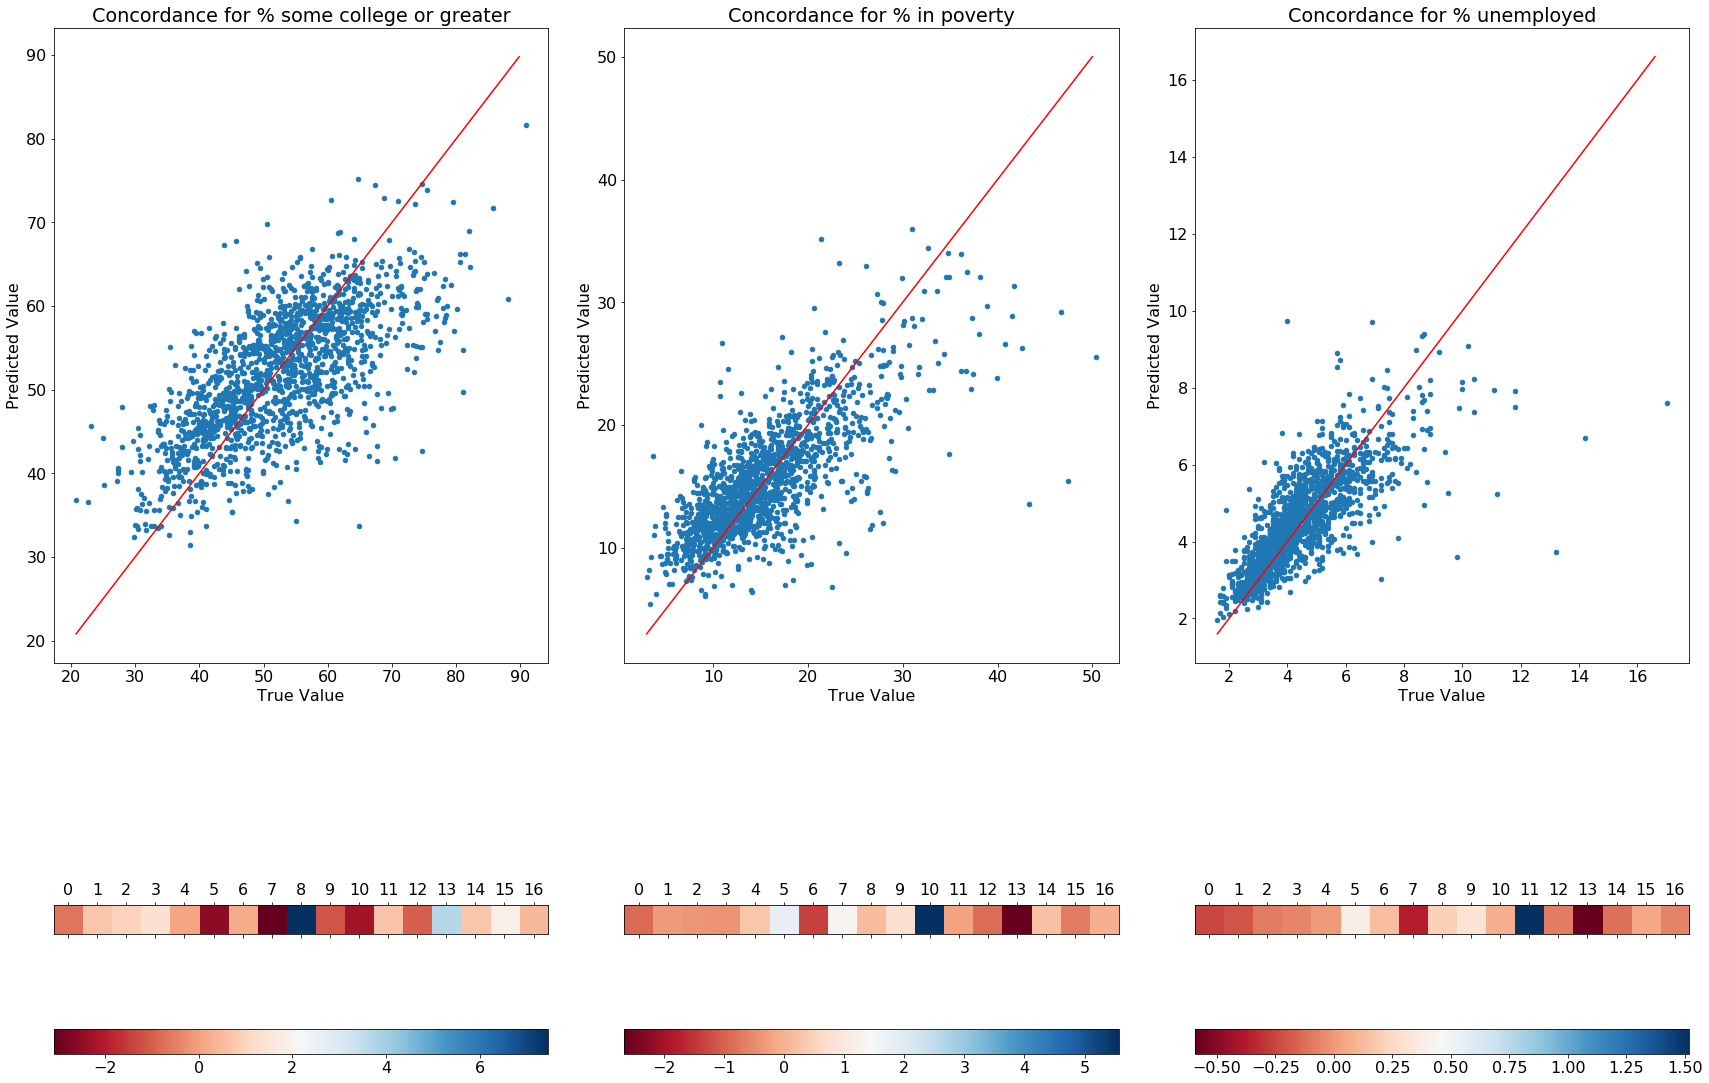

In [36]:
plot_concordance(neighbor_data, labels)
for i in range(17):
    print(i, feature_to_name[i])

# Neighbor + Within-County Regression

In [18]:
data = pickle.load(open('data/processed_data/clean_regression_2017', 'rb'))
adj_list = pickle.load(open('data/processed_data/adj_list', 'rb'))
idxs = data[:, 0]

neighbor_data = []
labels = []
for i in idxs:
    if i not in adj_list:
        continue
    
    # Prepare within-county labels
    label_data = data[idxs == i][0][1:]
    label_data[3] = label_data[3] + label_data[2]
    label_data = label_data[3:]
    labels.append(label_data)
    
    # Prepare neighbor-county features
    neighbors = adj_list[i]
    neighbor_attributes = []
    for n in neighbors:
        if n not in idxs:
            continue
        d = data[idxs == n][0][1:]
        d[3] = d[3] + d[2]
        d = d[3:]
        neighbor_attributes.append(d)
    neighbor_attributes = np.array(neighbor_attributes)
    min_attributes = np.min(neighbor_attributes, axis=0)
    max_attributes = np.max(neighbor_attributes, axis=0)
    mean_attributes = np.mean(neighbor_attributes, axis=0)
    std_attributes = np.std(neighbor_attributes, axis=0)
    feature_vec = np.concatenate((min_attributes, max_attributes, mean_attributes, std_attributes, label_data, np.array([len(neighbors)])))
    neighbor_data.append(feature_vec)
    
neighbor_data = np.array(neighbor_data)
labels = np.array(labels)
print(neighbor_data.shape, labels.shape)

(3091, 21) (3091, 4)


In [19]:
label_to_name = {
    0: 'index',
    #1: '% less than HS diploma',
    #2: '% only HS diploma',
    #3: '% some college',
    1: '% some college or greater',
    2: 'population',
    3: '% in poverty',
    4: '% unemployed',
}

feature_to_name = {
    0: 'min education',
    1: 'min population',
    2: 'min poverty',
    3: 'min unemployment',
    4: 'max education',
    5: 'max population',
    6: 'max poverty',
    7: 'max unemployment',
    8: 'mean education',
    9: 'mean population',
    10: 'mean poverty',
    11: 'mean unemployment',
    12: 'std education',
    13: 'std population',
    14: 'std poverty',
    15: 'std unemployment',
    16: '% some college or greater',
    17: 'population',
    18: '% in poverty',
    19: '% unemployed',
    20: 'number of neighbors'
}

In [20]:
def do_regression(data, labels, num_folds=5, seed=1234):        
    for i in range(labels.shape[1]):
        if label_to_name[i + 1] == 'population':
            continue
        
        kf = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
        # This does z-score normalization of data
        x = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
        x = x[:, np.delete(np.arange(0, 21), i + 16)]
        y = labels[:, i]
        
        mses = []
        maes = []
        for train_idx, test_idx in kf.split(x, y):
            x_train, y_train = x[train_idx], y[train_idx]
            x_test, y_test = x[test_idx], y[test_idx]
           
            model = LinearRegression(normalize=False, n_jobs=-1).fit(x_train, y_train)
            y_pred = model.predict(x_test)
            
            mses.append(mean_squared_error(y_test, y_pred))
            maes.append(mean_absolute_error(y_test, y_pred))
        
        print('\n=== {} ==='.format(label_to_name[i + 1]))
        print('Mean Squared Error: mean = {}, median = {}, std = {}, min = {}, max = {}'.format(np.mean(mses), np.median(mses), np.std(mses), np.min(mses), np.max(mses)))
        print('Mean Absolute Error: mean = {}, median = {}, std = {}, min = {}, max = {}'.format(np.mean(maes), np.median(maes), np.std(maes), np.min(maes), np.max(maes)))
        print('Label stats: min = {}, max = {}, mean = {}, std = {}'.format(np.min(y), np.max(y), np.mean(y), np.std(y)))

In [21]:
do_regression(neighbor_data, labels)


=== % some college or greater ===
Mean Squared Error: mean = 49.480496377592644, median = 46.2391045151468, std = 10.7588376449607, min = 37.8229891026359, max = 69.49262754321735
Mean Absolute Error: mean = 5.271479756751351, median = 5.26115953375413, std = 0.28082881488525996, min = 4.829302352962231, max = 5.665915345058265
Label stats: min = 15.3, max = 90.8, mean = 51.71015852474927, std = 10.639074817876304

=== % in poverty ===
Mean Squared Error: mean = 12.970476765508826, median = 12.570652614328807, std = 1.6933115463868742, min = 10.74037452656349, max = 15.966796650664449
Mean Absolute Error: mean = 2.5468481228359456, median = 2.5401187111891734, std = 0.09809624321057239, min = 2.39952350769643, max = 2.708803404272528
Label stats: min = 3.0, max = 56.7, mean = 15.393303138142995, std = 6.246585903489967

=== % unemployed ===
Mean Squared Error: mean = 0.7965719306867988, median = 0.6654508987380973, std = 0.2560746100996875, min = 0.5432855067039771, max = 1.1920793031

In [22]:
def plot_concordance(data, labels, seed=1234):
    fig, axes = plt.subplots(2, 3, figsize=(24, 16))
    idx = 0
    for i in range(labels.shape[1]):
        if label_to_name[i + 1] == 'population':
            continue
        
        kf = KFold(n_splits=2, shuffle=True, random_state=seed)
        # This does z-score normalization of data
        x = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
        x = x[:, np.delete(np.arange(0, 21), i + 16)]
        y = labels[:, i]
        
        for train_idx, test_idx in kf.split(x, y):
            x_train, y_train = x[train_idx], y[train_idx]
            x_test, y_test = x[test_idx], y[test_idx]
           
            model = LinearRegression(normalize=False, n_jobs=-1).fit(x_train, y_train)
            y_pred = model.predict(x_test)
            
            axes[0, idx].scatter(y_test, y_pred, s=20)
            axes[0, idx].plot(np.arange(np.min(y_test), np.max(y_test)), np.arange(np.min(y_test), np.max(y_test)), color='red')
            axes[0, idx].set_xlabel('True Value')
            axes[0, idx].set_ylabel('Predicted Value')
            axes[0, idx].set_title('Concordance for {}'.format(label_to_name[i + 1]))
            
            im = axes[1, idx].matshow(model.coef_[np.newaxis, :], cmap='RdBu')
            plt.colorbar(im, ax=axes[1, idx], orientation='horizontal')
            axes[1, idx].set_yticks([], [])
            other_idxs = [str(k) for k in range(16, 21)]
            other_idxs.remove(str(i + 16))
            axes[1, idx].set_xticks(np.arange(0, 20))
            axes[1, idx].set_xticklabels([str(k) for k in range(16)] + other_idxs)
            
            idx += 1
            break
    plt.tight_layout()
    plt.show()

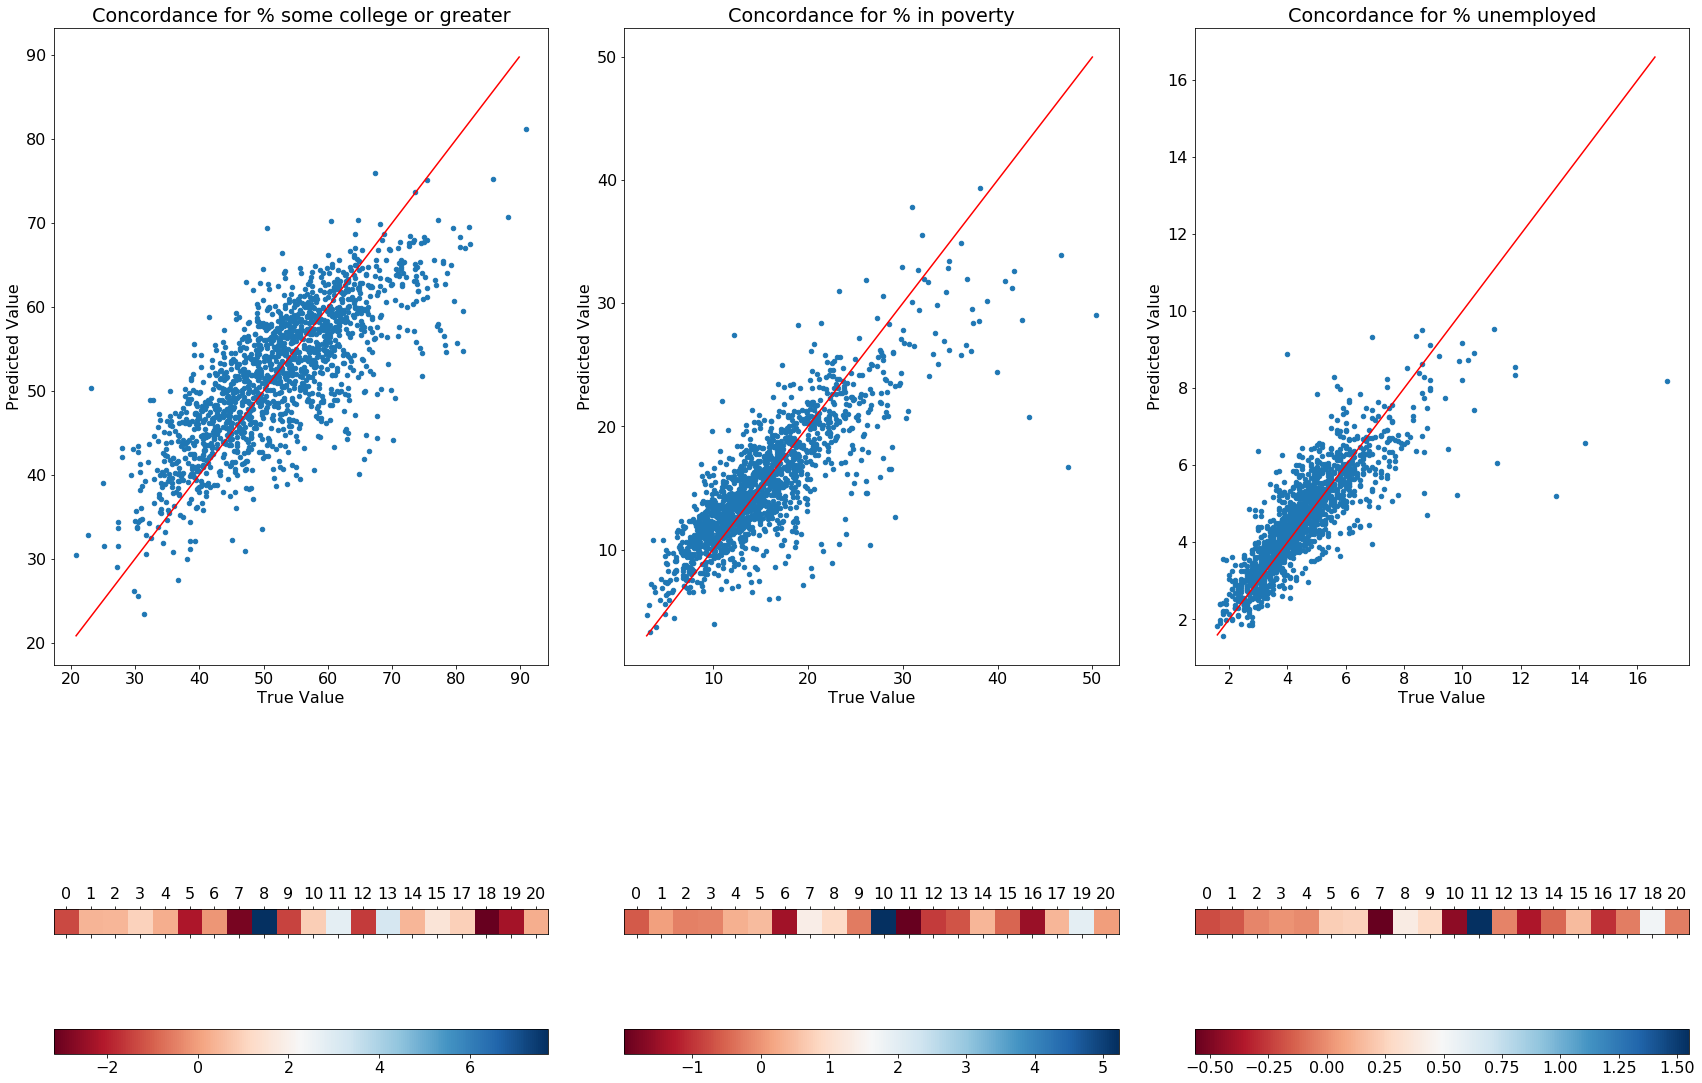

0 min education
1 min population
2 min poverty
3 min unemployment
4 max education
5 max population
6 max poverty
7 max unemployment
8 mean education
9 mean population
10 mean poverty
11 mean unemployment
12 std education
13 std population
14 std poverty
15 std unemployment
16 % some college or greater
17 population
18 % in poverty
19 % unemployed
20 number of neighbors


In [23]:
plot_concordance(neighbor_data, labels)
for i in range(21):
    print(i, feature_to_name[i])

# Neighbor + Within-County - Neighbor's Same Feature Regression

In [4]:
data = pickle.load(open('data/processed_data/clean_regression_2017', 'rb'))
adj_list = pickle.load(open('data/processed_data/adj_list', 'rb'))
idxs = data[:, 0]

neighbor_data = []
labels = []
for i in idxs:
    if i not in adj_list:
        continue
    
    # Prepare within-county labels
    label_data = data[idxs == i][0][1:]
    label_data[3] = label_data[3] + label_data[2]
    label_data = label_data[3:]
    labels.append(label_data)
    
    # Prepare neighbor-county features
    neighbors = adj_list[i]
    neighbor_attributes = []
    for n in neighbors:
        if n not in idxs:
            continue
        d = data[idxs == n][0][1:]
        d[3] = d[3] + d[2]
        d = d[3:]
        neighbor_attributes.append(d)
    neighbor_attributes = np.array(neighbor_attributes)
    min_attributes = np.min(neighbor_attributes, axis=0)
    max_attributes = np.max(neighbor_attributes, axis=0)
    mean_attributes = np.mean(neighbor_attributes, axis=0)
    std_attributes = np.std(neighbor_attributes, axis=0)
    feature_vec = np.concatenate((min_attributes, max_attributes, mean_attributes, std_attributes, label_data, np.array([len(neighbors)])))
    neighbor_data.append(feature_vec)
    
neighbor_data = np.array(neighbor_data)
labels = np.array(labels)
print(neighbor_data.shape, labels.shape)

(3091, 21) (3091, 4)


In [5]:
label_to_name = {
    0: 'index',
    #1: '% less than HS diploma',
    #2: '% only HS diploma',
    #3: '% some college',
    1: '% some college or greater',
    2: 'population',
    3: '% in poverty',
    4: '% unemployed',
}

feature_to_name = {
    0: 'min education',
    1: 'min population',
    2: 'min poverty',
    3: 'min unemployment',
    4: 'max education',
    5: 'max population',
    6: 'max poverty',
    7: 'max unemployment',
    8: 'mean education',
    9: 'mean population',
    10: 'mean poverty',
    11: 'mean unemployment',
    12: 'std education',
    13: 'std population',
    14: 'std poverty',
    15: 'std unemployment',
    16: '% some college or greater',
    17: 'population',
    18: '% in poverty',
    19: '% unemployed',
    20: 'number of neighbors'
}

In [26]:
def do_regression(data, labels, num_folds=5, seed=1234):        
    for i in range(labels.shape[1]):
        if label_to_name[i + 1] == 'population':
            continue
        
        kf = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
        # This does z-score normalization of data
        x = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
        delete_idxs = [k for k in range(0, 20) if k % 4 == i]
        print(delete_idxs)
        x = x[:, np.delete(np.arange(0, 21), delete_idxs)]
        y = labels[:, i]
        
        mses = []
        maes = []
        for train_idx, test_idx in kf.split(x, y):
            x_train, y_train = x[train_idx], y[train_idx]
            x_test, y_test = x[test_idx], y[test_idx]
           
            model = LinearRegression(normalize=False, n_jobs=-1).fit(x_train, y_train)
            y_pred = model.predict(x_test)
            
            mses.append(mean_squared_error(y_test, y_pred))
            maes.append(mean_absolute_error(y_test, y_pred))
        
        print('\n=== {} ==='.format(label_to_name[i + 1]))
        print('Mean Squared Error: mean = {}, median = {}, std = {}, min = {}, max = {}'.format(np.mean(mses), np.median(mses), np.std(mses), np.min(mses), np.max(mses)))
        print('Mean Absolute Error: mean = {}, median = {}, std = {}, min = {}, max = {}'.format(np.mean(maes), np.median(maes), np.std(maes), np.min(maes), np.max(maes)))
        print('Label stats: min = {}, max = {}, mean = {}, std = {}'.format(np.min(y), np.max(y), np.mean(y), np.std(y)))

In [27]:
do_regression(neighbor_data, labels)

[0, 4, 8, 12, 16]

=== % some college or greater ===
Mean Squared Error: mean = 71.26316644680108, median = 67.33658402257483, std = 10.180251956740564, min = 62.38645893746905, max = 91.1337921874957
Mean Absolute Error: mean = 6.461949865490955, median = 6.4705418705615925, std = 0.20890959076234117, min = 6.153237911140908, max = 6.7859802110852785
Label stats: min = 15.3, max = 90.8, mean = 51.71015852474927, std = 10.639074817876304
[2, 6, 10, 14, 18]

=== % in poverty ===
Mean Squared Error: mean = 19.14820716853115, median = 18.088442525454578, std = 2.3606088556224125, min = 16.442907935675066, max = 23.022676013371058
Mean Absolute Error: mean = 3.180385677431326, median = 3.0980186784247765, std = 0.11489970248482831, min = 3.0772081377165303, max = 3.36224699868268
Label stats: min = 3.0, max = 56.7, mean = 15.393303138142995, std = 6.246585903489967
[3, 7, 11, 15, 19]

=== % unemployed ===
Mean Squared Error: mean = 1.5058574934897526, median = 1.3692601051663833, std = 0.2

In [28]:
def plot_concordance(data, labels, seed=1234):
    fig, axes = plt.subplots(2, 3, figsize=(24, 16))
    idx = 0
    for i in range(labels.shape[1]):
        if label_to_name[i + 1] == 'population':
            continue
        
        kf = KFold(n_splits=2, shuffle=True, random_state=seed)
        # This does z-score normalization of data
        x = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
        delete_idxs = [k for k in range(0, 20) if k % 4 == i]
        x = x[:, np.delete(np.arange(0, 21), delete_idxs)]
        y = labels[:, i]
        
        for train_idx, test_idx in kf.split(x, y):
            x_train, y_train = x[train_idx], y[train_idx]
            x_test, y_test = x[test_idx], y[test_idx]
           
            model = LinearRegression(normalize=False, n_jobs=-1).fit(x_train, y_train)
            y_pred = model.predict(x_test)
            
            axes[0, idx].scatter(y_test, y_pred, s=20)
            axes[0, idx].plot(np.arange(np.min(y_test), np.max(y_test)), np.arange(np.min(y_test), np.max(y_test)), color='red')
            axes[0, idx].set_xlabel('True Value')
            axes[0, idx].set_ylabel('Predicted Value')
            axes[0, idx].set_title('Concordance for {}'.format(label_to_name[i + 1]))
            
            im = axes[1, idx].matshow(model.coef_[np.newaxis, :], cmap='RdBu')
            plt.colorbar(im, ax=axes[1, idx], orientation='horizontal')
            axes[1, idx].set_yticks([], [])
            axes[1, idx].set_xticks(np.arange(0, 16))
            axes[1, idx].set_xticklabels([str(k) for k in range(21) if k not in delete_idxs])
            
            idx += 1
            break
    plt.tight_layout()
    plt.show()

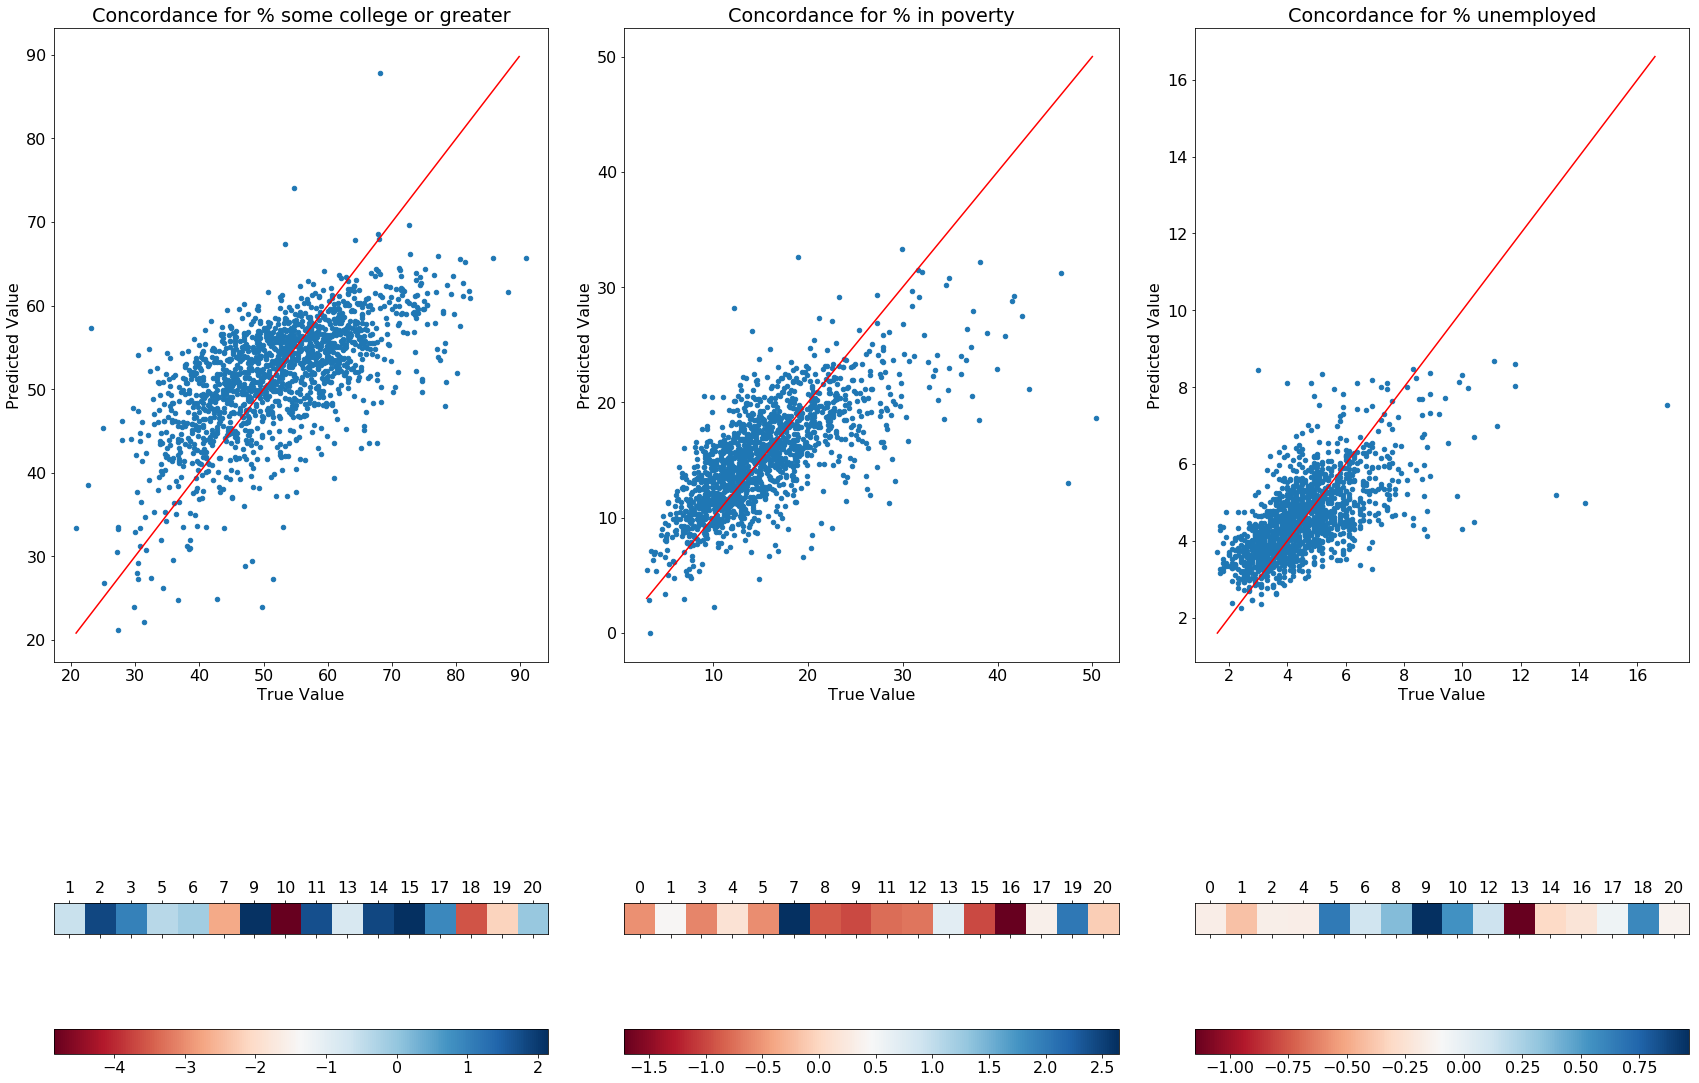

0 min education
1 min population
2 min poverty
3 min unemployment
4 max education
5 max population
6 max poverty
7 max unemployment
8 mean education
9 mean population
10 mean poverty
11 mean unemployment
12 std education
13 std population
14 std poverty
15 std unemployment
16 % some college or greater
17 population
18 % in poverty
19 % unemployed
20 number of neighbors


In [29]:
plot_concordance(neighbor_data, labels)
for i in range(21):
    print(i, feature_to_name[i])

# Null Model Regression

In [7]:
original_data = pickle.load(open('data/processed_data/clean_regression_2017', 'rb'))
adj_list = pickle.load(open('data/processed_data/adj_list', 'rb'))

null = NullModel(np.copy(original_data))
null.shuffle(n=1000000)
idxs = null.feature_matrix[:, 0]
data = null.feature_matrix

neighbor_data = []
labels = []
for i in idxs:
    if i not in adj_list:
        continue
    
    # Prepare within-county labels
    label_data = data[idxs == i][0][1:]
    label_data[3] = label_data[3] + label_data[2]
    label_data = label_data[3:]
    labels.append(label_data)
    
    # Prepare neighbor-county features
    neighbors = adj_list[i]
    neighbor_attributes = []
    for n in neighbors:
        if n not in idxs:
            continue
        d = data[idxs == n][0][1:]
        d[3] = d[3] + d[2]
        d = d[3:]
        neighbor_attributes.append(d)
    neighbor_attributes = np.array(neighbor_attributes)
    min_attributes = np.min(neighbor_attributes, axis=0)
    max_attributes = np.max(neighbor_attributes, axis=0)
    mean_attributes = np.mean(neighbor_attributes, axis=0)
    std_attributes = np.std(neighbor_attributes, axis=0)
    feature_vec = np.concatenate((min_attributes, max_attributes, mean_attributes, std_attributes, np.array([len(neighbors)])))
    neighbor_data.append(feature_vec)
    
neighbor_data = np.array(neighbor_data)
labels = np.array(labels)
print('\n', neighbor_data.shape, labels.shape)

999999 / 1000000
 (3091, 17) (3091, 4)


In [8]:
label_to_name = {
    0: 'index',
    #1: '% less than HS diploma',
    #2: '% only HS diploma',
    #3: '% some college',
    1: '% some college or greater',
    2: 'population',
    3: '% in poverty',
    4: '% unemployed',
}

feature_to_name = {
    0: 'min education',
    1: 'min population',
    2: 'min poverty',
    3: 'min unemployment',
    4: 'max education',
    5: 'max population',
    6: 'max poverty',
    7: 'max unemployment',
    8: 'mean education',
    9: 'mean population',
    10: 'mean poverty',
    11: 'mean unemployment',
    12: 'std education',
    13: 'std population',
    14: 'std poverty',
    15: 'std unemployment',
    16: 'number of neighbors'
}

In [9]:
def do_regression(data, labels, num_folds=5, seed=1234):        
    for i in range(labels.shape[1]):
        if label_to_name[i + 1] == 'population':
            continue
        
        kf = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
        # This does z-score normalization of data
        x = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
        y = labels[:, i]
        
        mses = []
        maes = []
        for train_idx, test_idx in kf.split(x, y):
            x_train, y_train = x[train_idx], y[train_idx]
            x_test, y_test = x[test_idx], y[test_idx]
           
            model = LinearRegression(normalize=False, n_jobs=-1).fit(x_train, y_train)
            y_pred = model.predict(x_test)
            
            mses.append(mean_squared_error(y_test, y_pred))
            maes.append(mean_absolute_error(y_test, y_pred))
        
        print('\n=== {} ==='.format(label_to_name[i + 1]))
        print('Mean Squared Error: mean = {}, median = {}, std = {}, min = {}, max = {}'.format(np.mean(mses), np.median(mses), np.std(mses), np.min(mses), np.max(mses)))
        print('Mean Absolute Error: mean = {}, median = {}, std = {}, min = {}, max = {}'.format(np.mean(maes), np.median(maes), np.std(maes), np.min(maes), np.max(maes)))
        print('Label stats: min = {}, max = {}, mean = {}, std = {}'.format(np.min(y), np.max(y), np.mean(y), np.std(y)))

In [10]:
do_regression(neighbor_data, labels)


=== % some college or greater ===
Mean Squared Error: mean = 114.01350685096665, median = 114.0220301796744, std = 9.128933055764856, min = 98.96369407590956, max = 125.20747487331319
Mean Absolute Error: mean = 8.65101505160484, median = 8.682305909581048, std = 0.3121025545203255, min = 8.091534409538891, max = 8.946187216997169
Label stats: min = 15.3, max = 90.8, mean = 51.70967324490456, std = 10.639261217427727

=== % in poverty ===
Mean Squared Error: mean = 39.065138777020536, median = 38.913816236721495, std = 2.650846899888793, min = 36.11175876652998, max = 43.759013565724906
Mean Absolute Error: mean = 4.741627839327473, median = 4.711595018937704, std = 0.12033817761253617, min = 4.583007161905584, max = 4.9527090404106975
Label stats: min = 3.0, max = 56.7, mean = 15.39301197023617, std = 6.246528354702884

=== % unemployed ===
Mean Squared Error: mean = 2.461646220753212, median = 2.4958710245829017, std = 0.3954120911509338, min = 1.9215876114818873, max = 2.9595801988

In [23]:
def plot_concordance(data, labels, seed=1234):
    fig, axes = plt.subplots(2, 3, figsize=(24, 16))
    idx = 0
    for i in range(labels.shape[1]):
        if label_to_name[i + 1] == 'population':
            continue
        
        kf = KFold(n_splits=2, shuffle=True, random_state=seed)
        # This does z-score normalization of data
        x = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
        y = labels[:, i]
        
        for train_idx, test_idx in kf.split(x, y):
            x_train, y_train = x[train_idx], y[train_idx]
            x_test, y_test = x[test_idx], y[test_idx]
           
            model = LinearRegression(normalize=False, n_jobs=-1).fit(x_train, y_train)
            y_pred = model.predict(x_test)
            
            axes[0, idx].scatter(y_test, y_pred, s=20)
            axes[0, idx].plot(np.arange(np.min(y_test), np.max(y_test)), np.arange(np.min(y_test), np.max(y_test)), color='red')
            axes[0, idx].set_xlabel('True Value')
            axes[0, idx].set_ylabel('Predicted Value')
            axes[0, idx].set_title('Concordance for {}'.format(label_to_name[i + 1]))
            axes[0, idx].axhline(y=np.mean(y_train), color='orange', linewidth=3)
            
            im = axes[1, idx].matshow(model.coef_[np.newaxis, :], cmap='RdBu')
            plt.colorbar(im, ax=axes[1, idx], orientation='horizontal')
            axes[1, idx].set_yticks([], [])
            axes[1, idx].set_xticks(np.arange(0, 17))
            
            idx += 1
            break
    plt.tight_layout()
    plt.show()

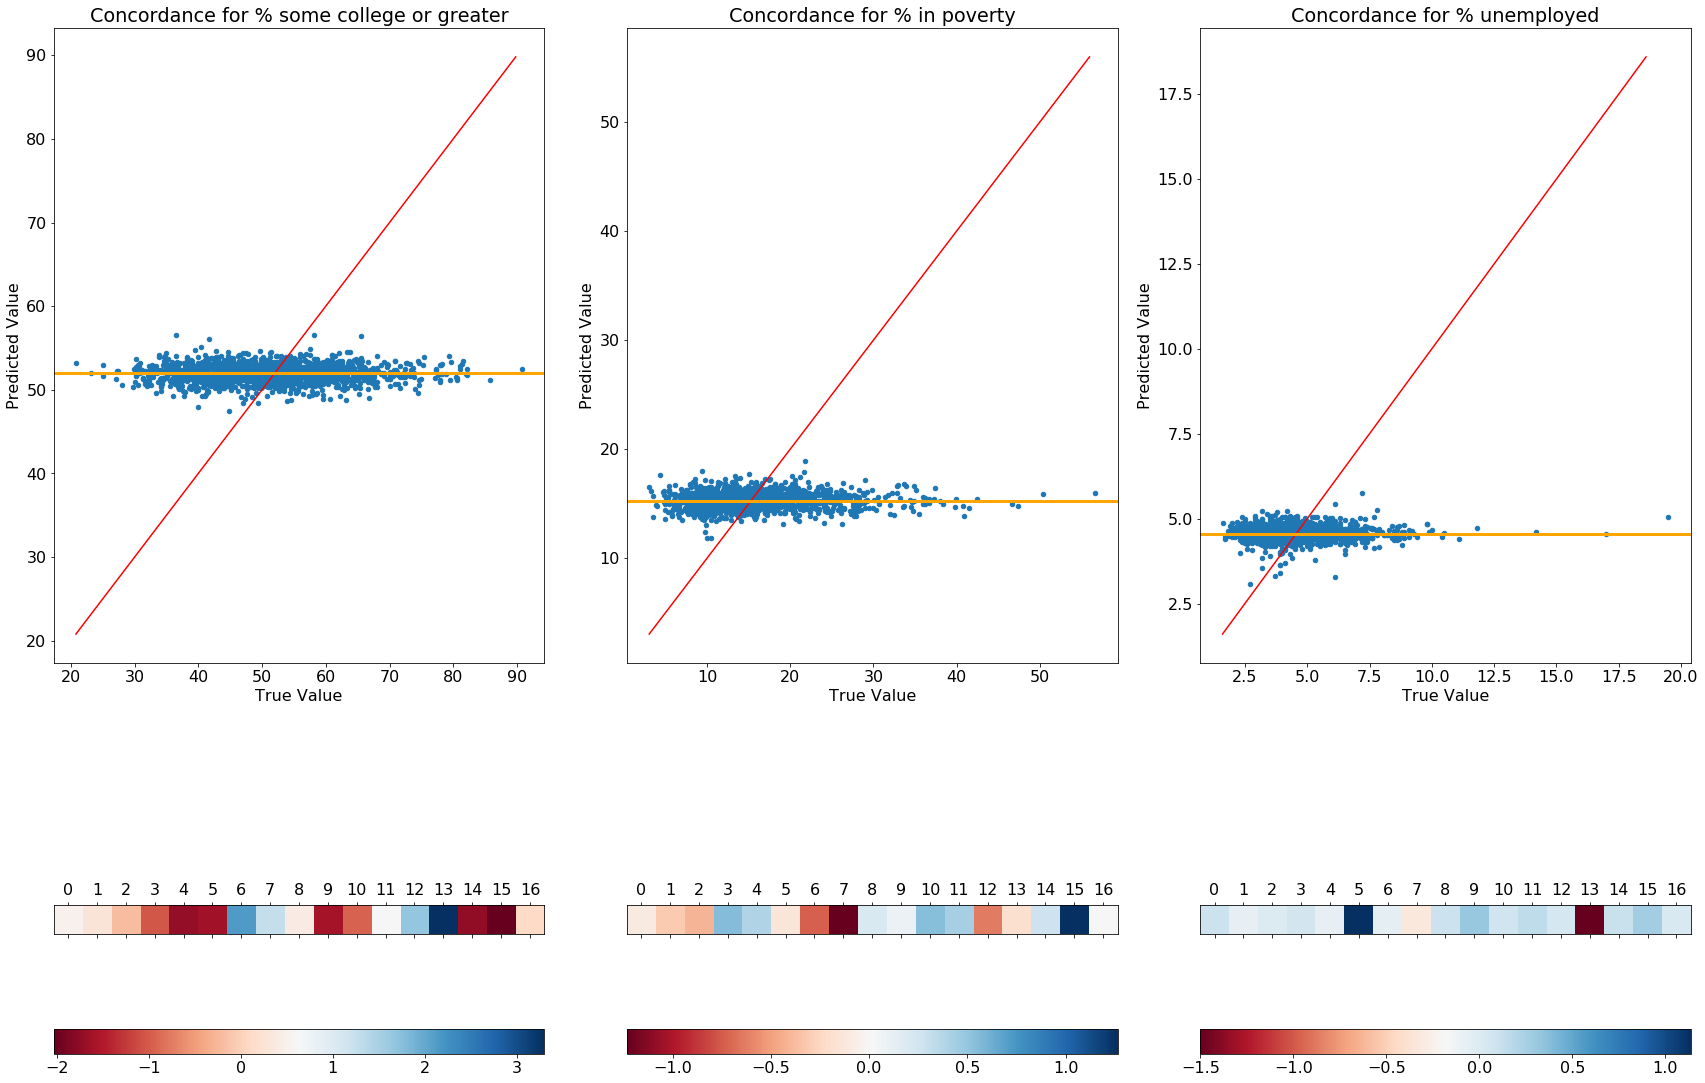

0 min education
1 min population
2 min poverty
3 min unemployment
4 max education
5 max population
6 max poverty
7 max unemployment
8 mean education
9 mean population
10 mean poverty
11 mean unemployment
12 std education
13 std population
14 std poverty
15 std unemployment
16 number of neighbors


In [24]:
plot_concordance(neighbor_data, labels)
for i in range(17):
    print(i, feature_to_name[i])